In [14]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython
import soundfile as sf

# Short Time Fourier Transform
The short-time Fourier transform (STFT) is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. Unlike the standard Fourier Transform, which gives you the overall frequency content of a signal, the STFT breaks the signal into short, overlapping segments (windows) and computes the frequency spectrum for each segment.  One then usually plots the changing spectra as a function of time, known as a spectrogram.


### Why use STFT at all?

STFTs as well as standard Fourier transforms and other tools are frequently used to analyze music. The spectrogram can, for example, show frequency on the horizontal axis, with the lowest frequencies at left, and the highest at the right. The height of each bar (augmented by color) represents the amplitude of the frequencies within that band. The depth dimension represents time, where each new bar was a separate distinct transform. Audio engineers use this kind of visual to gain information about an audio sample, for example, to locate the frequencies of specific noises (especially when used with greater frequency resolution) or to find frequencies which may be more or less resonant in the space where the signal was recorded.

As a tool it is pretty straightforward and there are multiple libraries implementing it already fast enough that we usually don't bother with its internal implementation (though since this notebook aims to teach how it works, we will look into it as well). For now let's see what it usually looks like:

Our sound:


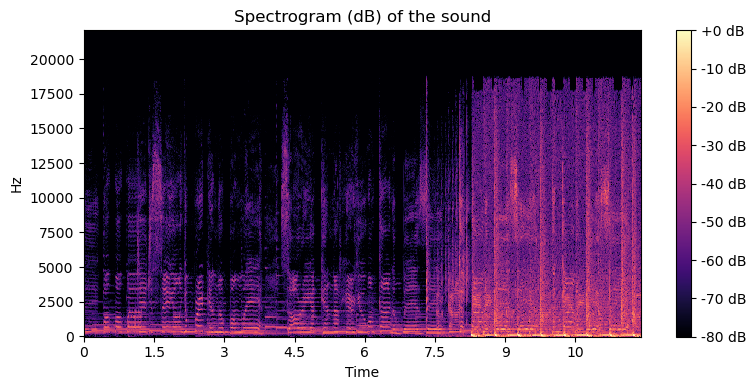

In [15]:
y, sr = librosa.load('short_ladygaga_telephone.mp3', sr=None)
D = librosa.stft(y, n_fft=1024, hop_length=512, window='hann')
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
print("Our sound:")
IPython.display.display(IPython.display.Audio("short_ladygaga_telephone.mp3"))

plt.figure(figsize=(8, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.title('Spectrogram (dB) of the sound')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Beautiful but we don't really know what we're looking at, right? Let's focus on a specific type of audiofile: speech.
We will observe how different letters/sounds emerge in the spectogram.

Our sound:


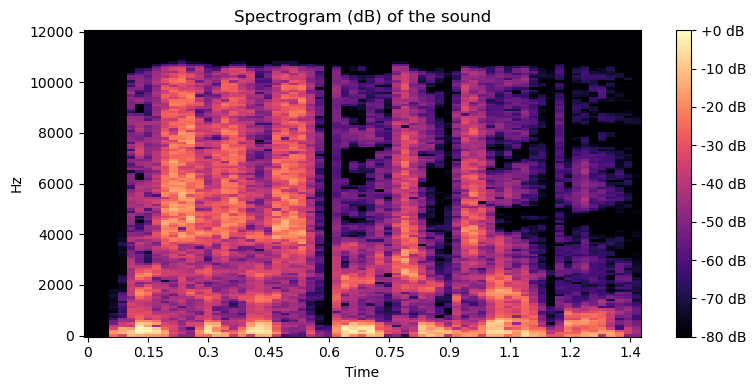

In [16]:
print("Our sound:")
IPython.display.display(IPython.display.Audio("speech.mp3"))
y, sr = sf.read("speech.mp3")

D = librosa.stft(y, n_fft=256, hop_length=512, window='hann')
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(8, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.title('Spectrogram (dB) of the sound')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Here are a few things we can observe:

    -Horizontal lines in a comb-structure correspond to the fundamental frequency.
    -Vertical lines correspond to abrupt sounds, which are often characterized as transients. Typical transients in speech are stop consonants.
    -Areas which have a lot of energy in the high frequencies (appears as a lighter colour), correspond to noisy sounds like fricatives.

The spectrogram of the envelope structure however still has two distinct components, visible as rapid and smooth changes over time. The rapid events correspond to plosives like /p/, /t/ and /k/ sounds, while the slow changes are generated by changes in the vocal tract, which define the vowels. By a similar approach as the above frequency envelope extraction, we can separate such rapid and smooth changes over time.

In the spectrogram image with the smoothed time structure (and smoothed frequency structure), we can see that the vertical lines corresponding to distinct events in time have been removed. They typically correspond to stops and plosives like /t/, /p/, /b/, /g/ and /k/. Correspondingly, in the spectrogram image of the fine time structrure, we see only vertical lines. The bright vertical lines are often preceeded by dark areas (i.e. on the left side). These are stop consonants, where airflow (and thus sound) is completely stopped before the release. The dark patches thus correspond to an absence of sound, the stop and the following bright lines to the release. Note that voiced consonants like /b/ do not necessarily have a stop part, as the voiced sound can continue throughout the phoneme.


Now that we know why its useful, we can dive in and try to implement our own implementation.

----
Some helper functions to not waste time and be redundant.

In [17]:
def sinc(x):
    """
    Calculates the sinc function: sin(pi*x) / (pi*x) for x != 0, 1 for x = 0.
    """
    output = np.zeros_like(x)
    i=0
    for value in x:
        if value == 0:
            output[i] = 1 
        else:
            output[i] = np.sin(np.pi * value) / (np.pi * value)
        i+=1
    return output

def gauss_function(a):
    """Sampling φ₀(t) = a^{1/4} e^{-π a t²} on a uniform grid."""

    return lambda x : a**(1/4)*np.exp(-(x**2)*a*np.pi)


def plot_stft(X, title, window_length, sr):
    times = np.arange(X.shape[0]) * window_length / sr
    freqs = np.fft.fftfreq(window_length, d=1/sr)
    X_sh = np.fft.fftshift(X, axes=1)
    f_sh = np.fft.fftshift(freqs) 
    plt.figure()
    plt.pcolormesh(times, f_sh, np.abs(X_sh).T, shading='gouraud')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar(label='Magnitude')
    plt.tight_layout()
    plt.show()

def plot_signal(t, x, title="Signal", n_points=100):
    """
    Helper function to plot a signal with time axis.
    Plots the first n_points by default.

    Parameters
    ----------
    t : array-like
        Time axis.
    x : array-like
        Signal values.
    title : str
        Title of the plot.
    n_points : int
        Number of points to plot from the start.
    """
    plt.figure(figsize=(10, 4))
    plt.plot(t[:n_points], x[:n_points])
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

## Why use STFT at all?

Many real-world signals (like music or speech) change over time. As we said, the STFT lets us see both when and which frequencies are present. However there is a trade-off between them: 
Shorter windows give better time resolution but worse frequency resolution, and vice versa. The choice of window length and hop size affects this balance.


We will implement the most basic STFT and thus we need to focus on a couple of things:

1. **Windowing:**  
   The signal is divided into short sections using a window function (here, a Gaussian window). This window slides along the signal, focusing on a small part at a time.

2. **Sliding (Hop):**  
   The window moves forward by a fixed number of samples (the "hop length"). If the hop is smaller than the window, the windows overlap, giving smoother time resolution.

3. **Local Spectrum:**  
   For each windowed segment, the Discrete Fourier Transform (DFT) is computed. This gives the frequency content present in that short time segment.

The result is a 2D array (matrix) where each row corresponds to a time segment and each column to a frequency bin. This matrix shows how the frequencies in the signal evolve

Since STFT logically corresponds to taking a signal, dividing it into chunks and applying FT to windowed chunks,
here is the mathematical formula of it:
$$ X(m, k) = \sum_{n=0}^{L-1} x[n + mH] \cdot w[n] \cdot e^{-j 2\pi k n / L} $$

  where,  
$x[n]$: Input signal  
$w[n]$: Window function (e.g., Gaussian) of length $L$  
$m$: Frame (window) index  
$H$: Hop size (number of samples between frames)  
$k$: Frequency bin index ($k = 0, 1, ..., L-1$)  
$L$: Window length (number of samples in each frame)  
$X(m, k)$: STFT coefficient at time frame $m$ and frequency bin $k$  
  
And here is a straightforward implementation of it using gaussian window:

In [18]:
def simple_stft(x, window_length, hop_length, a):
    """
    stft with overlap

    Parameters
    ----------
    x : input real-valued signal.
    window_length : length in samples
    hop_length : int
        Number of samples to advance between successive frames.
        If hop_length < window_length, frames will overlap.
    a :  for the Gaussian window (standard deviation factor).

    Returns
    -------
    X : 2D complex array, shape (n_frames, window_length)
        STFT matrix: each row is the FFT of one windowed frame.
    """
    n_frames = int(1 + (len(x) - window_length) // hop_length)
    X = np.zeros((n_frames, window_length), dtype=complex)

    t = np.arange(window_length) - (window_length // 2)
    window = gauss_function(a)(t)

    for m in range(n_frames):
        start = m * hop_length
        segment = x[start : start + window_length]
        for k in range(window_length):
            total = 0+0j
            for n in range(window_length):
                total += segment[n] * window[n] * np.exp(-1j * 2 * np.pi * k * n / window_length)
            X[m, k] = total

    return X

Now let's test it with some values and simple functions. Here is a thing to keep in mind:
    The frequency bins are delta_f = fs/window length multiples so its better if f0 is a multiple of it.
  


## Example 1: Pure Cosine Wave

This example analyzes a simple cosine wave at 10 Hz.  
You should see a strong frequency component at 10 Hz throughout the signal.

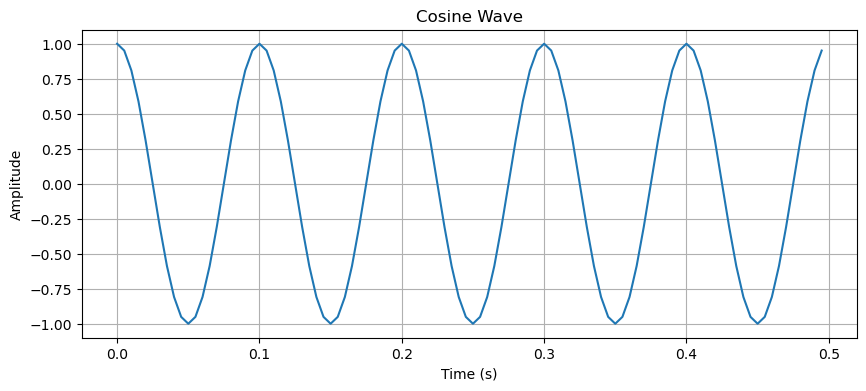

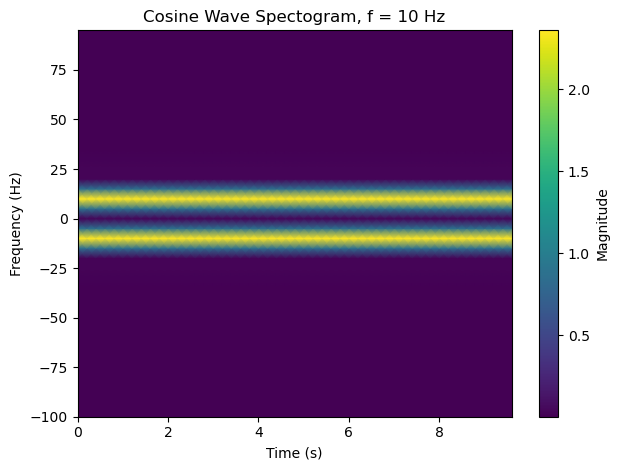

In [19]:
# --- Example 1: Pure Cosine Wave ---
f0 = 10            # Frequency (Hz)
sr = 200           # Sampling rate (Hz)
duration = 5.0     # Duration (seconds)
N = int(duration * sr)
n = np.arange(N)
t = n / sr
x = np.cos(2 * np.pi * f0 * t)

window_length = 40
a = 1 / window_length / 15

X = simple_stft(x, window_length=window_length, hop_length=window_length // 2, a=a)

plot_signal(t, x, title="Cosine Wave", n_points=100)
plot_stft(X, 'Cosine Wave Spectogram, f = 10 Hz', window_length, sr)

## Example 2: Sinc Function

Here, we analyze a sinc function, which is localized in time and has a broad frequency spectrum. Notice with a DFT knowledge alone, we can expect to see a rectengular-like form in general in frequency components with proper parameter choices.

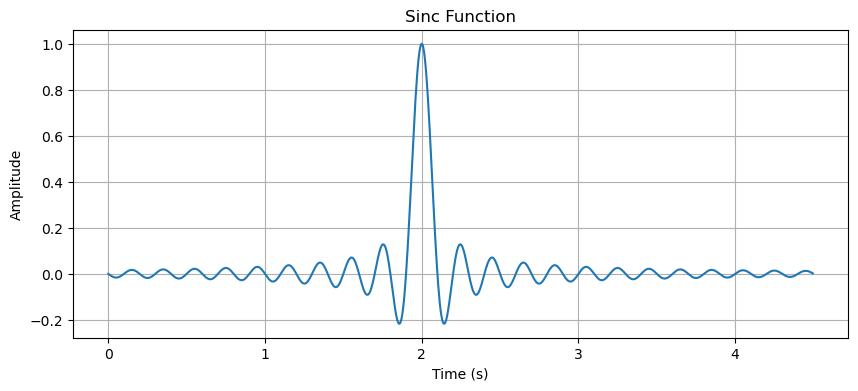

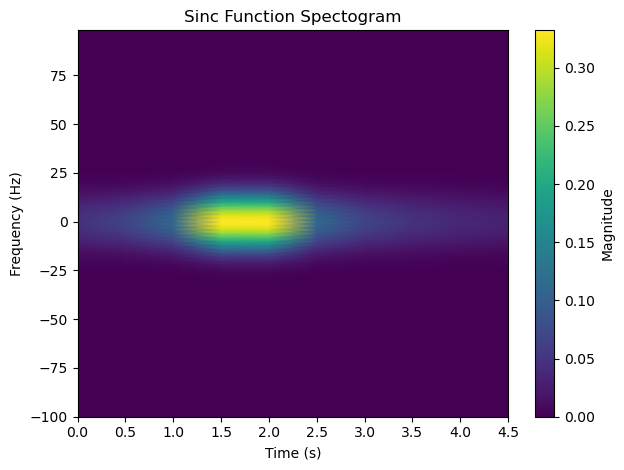

In [20]:
# --- Example 2: Sinc Function ---
x2 = sinc(f0 * t - 20)
window_length = 100
a = 1 / window_length

X2 = simple_stft(x2, window_length, window_length, a)
plot_signal(t, x2, title="Sinc Function", n_points=900)
plot_stft(X2, 'Sinc Function Spectogram', window_length, sr)

## Example 3: Exponential Polynomial
This signal is a simple exponential minus a linear term.
It is not periodic, so its frequency content is more spread out.

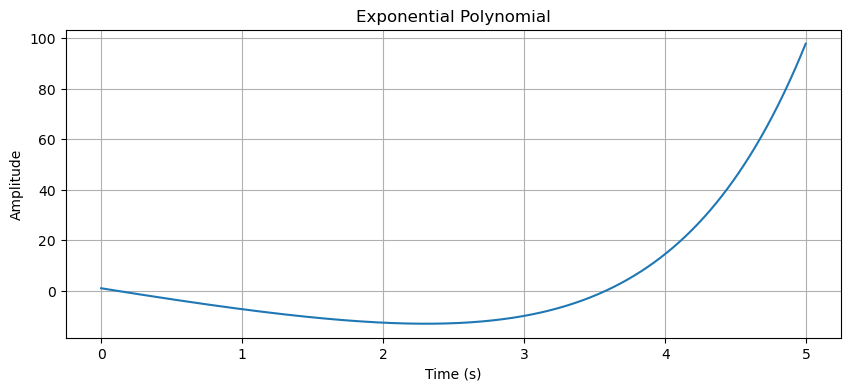

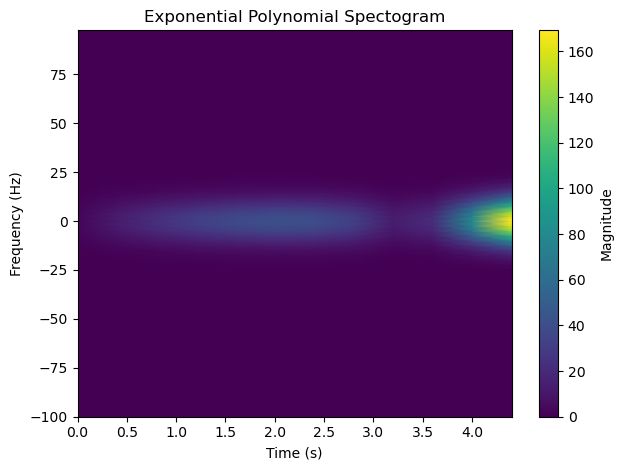

In [36]:
# --- Example 3: Exponential Polynomial ---
x3 = np.exp(t) - t * 10
window_length = 80

X3 = simple_stft(x3, window_length, window_length, a)
plot_signal(t, x3, title="Exponential Polynomial", n_points=1000)
plot_stft(X3, 'Exponential Polynomial Spectogram', window_length, sr)

Now that we've looked at some very basic functions, let's modify them a little.  
## What is a Chirp Signal?

A **chirp** is a signal in which the frequency increases (or decreases) over time.  
Chirps are widely used in radar, sonar, and communications, and are a classic example of a non-stationary signal.

- **Linear chirp:** The frequency changes at a constant rate.
- **Quadratic or exponential chirp:** The frequency changes nonlinearly.

In a linear chirp, the instantaneous frequency at time $t$ is given by:
$$
f(t) = f_0 + k t
$$
where $f_0$ is the starting frequency and $k$ is the rate of frequency increase (chirp rate).

The general form of a linear chirp signal is:
$$
x(t) = \cos\left(2\pi \left(f_0 t + \frac{k}{2} t^2\right)\right)
$$

Below is an example of a linear chirp signal, where the frequency sweeps from 5 Hz to 50 Hz over 2 seconds.

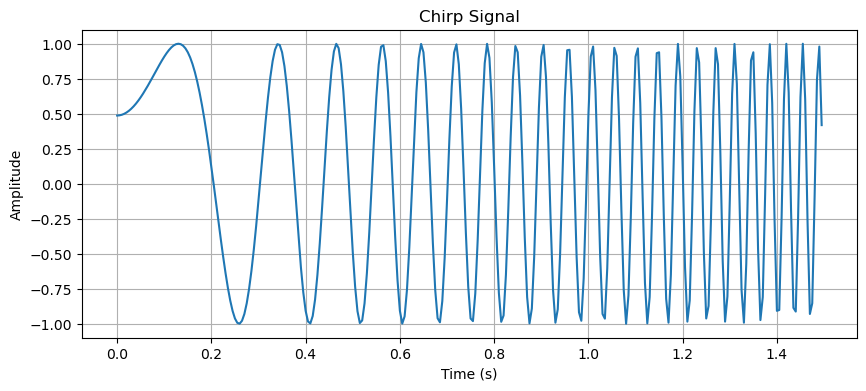

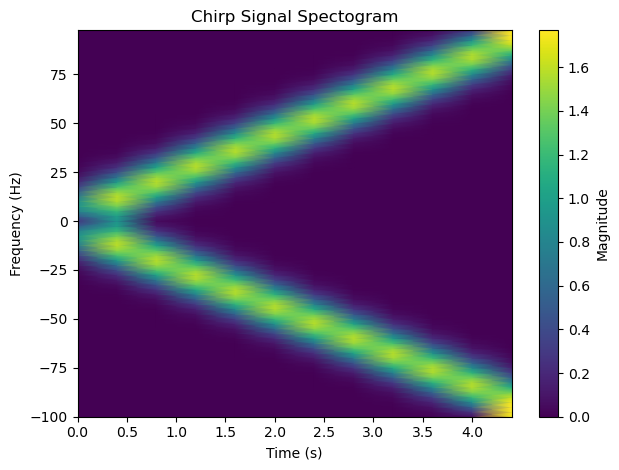

In [179]:
chirp_signal = np.cos(2*np.pi*t**2*f0+200)
plot_signal(t, chirp_signal, title='Chirp Signal', n_points=300)
plot_stft(simple_stft(chirp_signal, window_length, window_length, a), 'Chirp Signal Spectogram', window_length, sr)

Take a look at its spectrogram. One significant property of the chirp signal is that when you multiply another function by a chirp, it causes a "shearing" or "rotation" effect in the time-frequency plane. This means the frequency content of the original function is shifted in a way that depends on time, resulting in the slanted or rotated appearance you see in the spectrogram. This visual effect directly reflects the time-varying frequency introduced by the chirp modulation.

## Example 4: Sinc Modulated by a Chirp
This example multiplies the sinc function by a chirp (a signal whose frequency increases over time), so you should see the frequency content "move" in the plot.

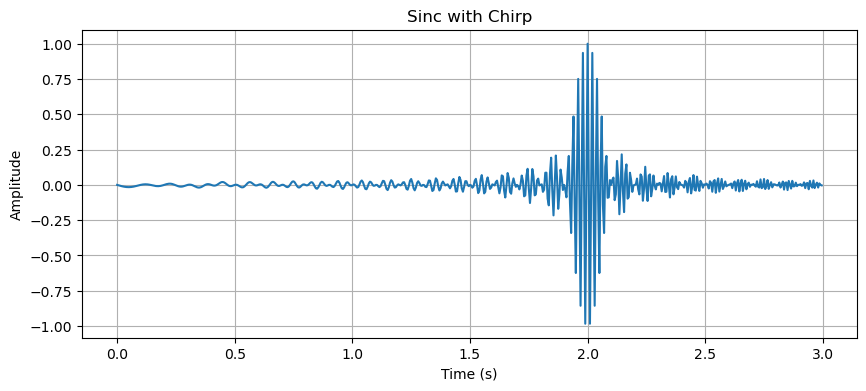

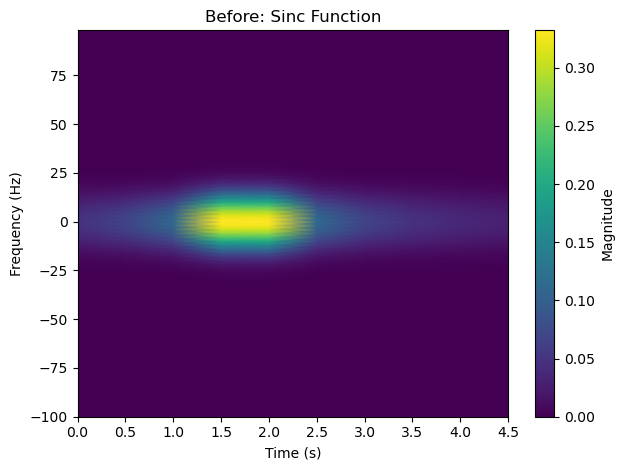

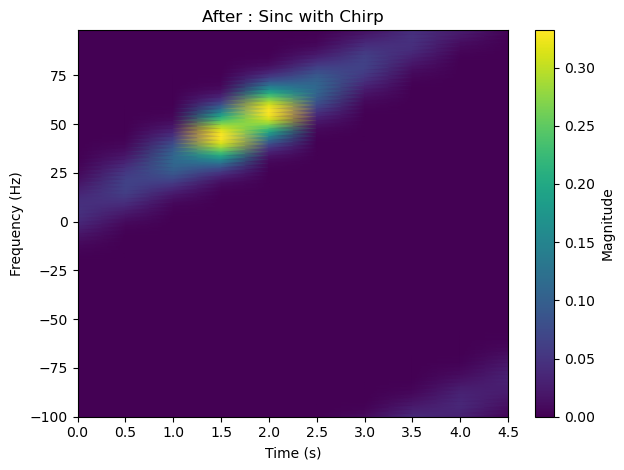

In [180]:
# --- Example 4: Sinc Modulated by a Chirp ---
window_length = 100
a = 1 / window_length
x5 = x2 * np.exp(1j * np.pi * (t ** 2) * 25)  # or 60, 80, etc.
X5 = simple_stft(x5, window_length, window_length, a)

plot_signal(t, x5, title='Sinc with Chirp', n_points=600)
plot_stft(X2, 'Before: Sinc Function', window_length, sr)
plot_stft(X5, 'After : Sinc with Chirp', window_length, sr)

## Example 5: Exponential Polynomial Modulated by Chirp
This is the previous signal modulated by a chirp, so you should see both the spread-out spectrum and the time-varying frequency.

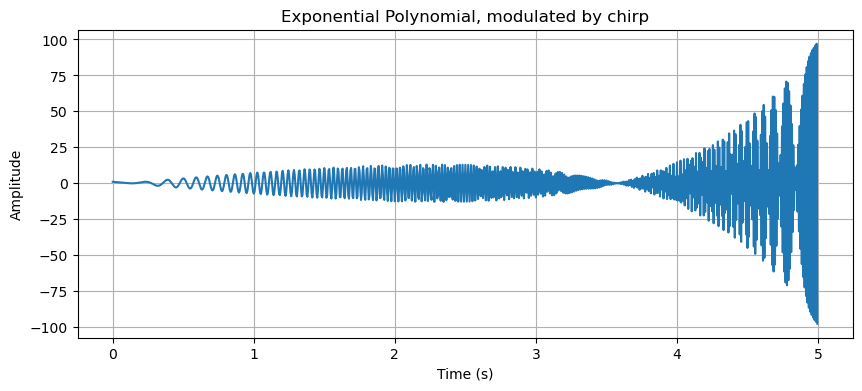

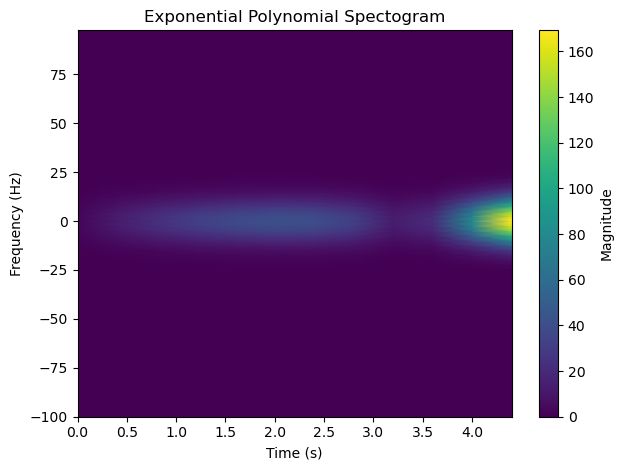

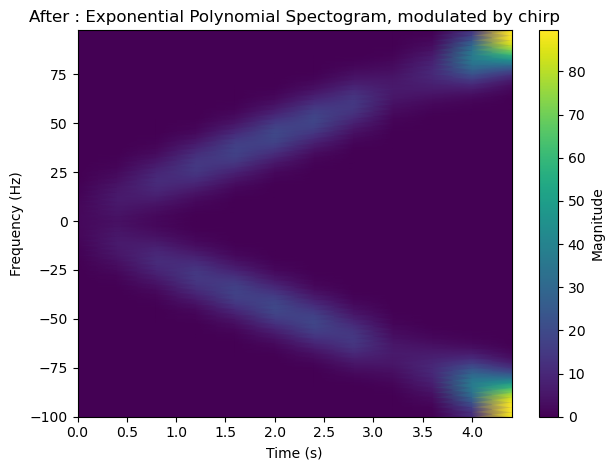

In [181]:
# --- Example 5: Exponential Polynomial Modulated by Chirp ---
window_length = 80
a = 1 / (window_length)
x4 = x3 * np.cos(10 * 2 * np.pi * t **2) 
X4 = simple_stft(x4, window_length, window_length, a)

plot_signal(t, x4, title="Exponential Polynomial, modulated by chirp", n_points=1000)
plot_stft(X3, 'Exponential Polynomial Spectogram', window_length, sr)
plot_stft(X4, 'After : Exponential Polynomial Spectogram, modulated by chirp', window_length, sr)

## A Different STFT Implementation: Full-Signal Sliding Window (my_stft2)

The function `my_stft2` provides an alternative approach to the Short-Time Fourier Transform (STFT) compared to the previous `simple_stft` function.

### How does this version work?

- **Global Windowing:**  
  Instead of extracting short segments, this method applies a window (typically Gaussian) to the **entire signal** for each frame, but the window is shifted in time so that it is centered at different positions.
- **Sliding the Window:**  
  For each frame, the window is centered at `center = m * hop`. The window function is shifted accordingly, and the FFT is computed for the entire signal, but only the region under the window contributes significantly.
- **Smoother Spectrogram:**  
  Because the window is always the same length as the signal and smoothly slides across all positions, the resulting spectrogram is **much smoother** in both time and frequency compared to the basic segment-based STFT. This is especially true when using a Gaussian window, which decays smoothly at the edges and avoids sharp discontinuities.

### Mathematical Formula

For each frame $m$, the window is centered at position $center = m \cdot hop$. The window function is shifted accordingly, and the DFT is computed as:

$$
X[m, k] = \sum_{i=0}^{N-1} x[i] \cdot w(i - center) \cdot e^{-j 2\pi k i / N}
$$

where:
- $x[i]$ is the input signal,
- $w(i - center)$ is the window function centered at the current frame,
- $k$ is the frequency bin index,
- $N$ is the total signal length.

---

### Implementation

In [41]:
def my_stft2(x, hop, a):
    """
    Custom STFT implementation using a sliding window over the full signal,
    but using numpy's FFT for each windowed frame.

    Parameters
    ----------
    x : array-like
        Input real-valued signal.
    hop : int
        Hop size (number of samples between frames).
    a : float
        Parameter for the Gaussian window.

    Returns
    -------
    X : 2D complex array, shape (frame_count, N)
        STFT matrix: each row is the FFT of the full signal windowed and centered at a different time.
    """
    N = len(x)
    frame_count = N // hop
    n = np.arange(N)
    X = np.zeros((frame_count, N), dtype=complex)
    window = gauss_function(a)

    for m in range(frame_count):
        center = m * hop
        w_full = window(n - center)
        windowed_signal = x * w_full
        X[m, :] = np.fft.fft(windowed_signal)
    return X


Some basic examples:

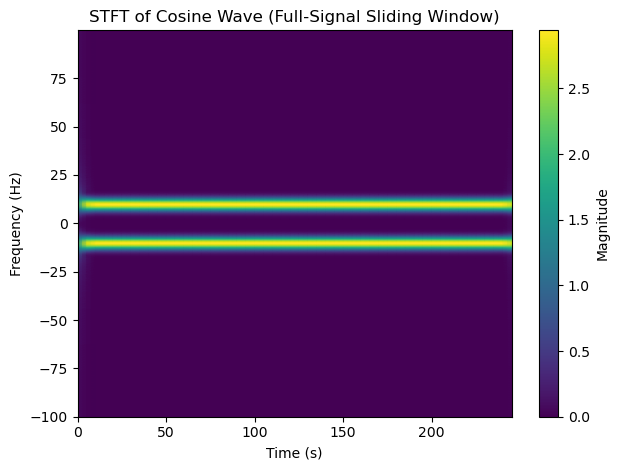

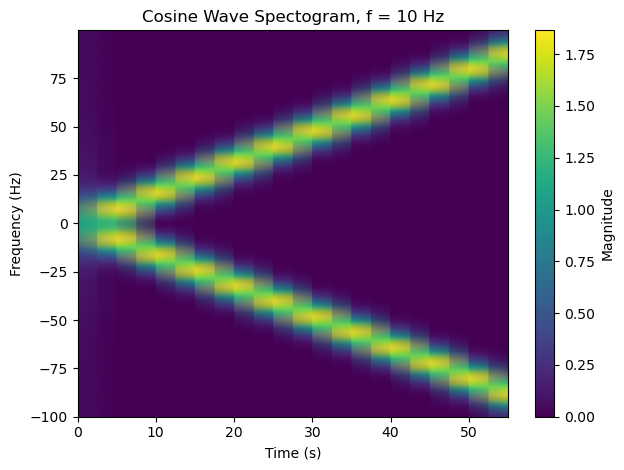

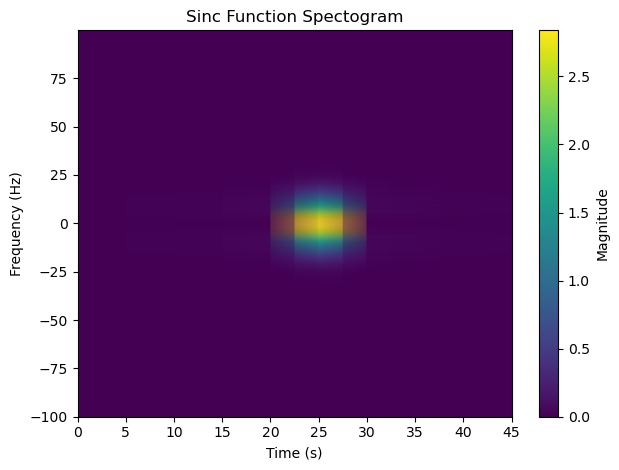

In [42]:
f0 = 10
sr = 200
duration = 5.0   # seconds
N = int(duration * sr)
n = np.arange(N)
t = n / sr
x1 = np.cos(2 * np.pi * f0 * t)
x2 = np.cos(2*np.pi*t**2*f0+200)
center_time = (t[-1] - t[0]) / 2
x3 = sinc(f0 * (t - center_time))
#x3 = sinc(t*f0)
window_length1 = 20
window_length2 = 80
window_length3 = 100 
a1 = 1 / window_length / 15
a2= 1/window_length*3/7
a3 = 1 / (window_length3*0.8)
X1 = my_stft2(x1, window_length1, a1)
plot_stft(X1, 'STFT of Cosine Wave (Full-Signal Sliding Window)', N, sr)
X2 = my_stft2(x2, window_length2, a2)
plot_stft(X2, 'Cosine Wave Spectogram, f = 10 Hz', N, sr)
X3 = my_stft2(x3, window_length3, a3)
plot_stft(X3, 'Sinc Function Spectogram', N, sr)

### Why is this version smoother?

- **No abrupt window edges:** The Gaussian window smoothly tapers off, so there are no sharp jumps at the window boundaries.
- **Full overlap:** Each frame uses the entire signal, just with the window shifted, so there is maximal overlap between frames.
- **Continuous time-frequency coverage:** The result is a time-frequency representation that is less "blocky" and more continuous, especially for non-stationary signals.  
 
  
---

**Note on Index Shifting:**  
In some mathematical definitions of the STFT (such as in certain papers), the window is shifted using an index formula like  
`window[(l - k*hop) % N]` where,  
- `l` is the signal sample index,  
- `k` is the frame (window) index,  
- `hop` is the hop size (number of samples between frames),  
- and `N` is the total signal length.

This formula shifts the window so that it is centered at the correct position for each frame. It is mathematically equivalent to shifting the window center as done in `my_stft2`. Both approaches ensure the window is centered at the right time for each frame; the difference is just in how the shift is expressed.

In [43]:
def my_stft3(x, hop, a):
    """
    Custom STFT with Gaussian window using full-length signal and numpy FFT.

    Parameters
    ----------
    x : array-like, shape (N,)
        Input real-valued signal.
    hop : int
        Hop size (samples between adjacent frames).
    a : float
        Width parameter for the Gaussian window.

    Returns
    -------
    X : 2D complex ndarray, shape (frame_count, N)
        STFT matrix: each row is the FFT of a windowed frame.
    """
    x = np.asarray(x)
    N = len(x)
    frame_count = N // hop
    X = np.zeros((frame_count, N), dtype=complex)
    
    n = np.arange(N)
    g = gauss_function(a)

    for m in range(frame_count):
        center = m * hop
        # Use modulo-based shifting:
        shifted_n = (n - center) % N
        w = g(shifted_n)
        windowed = x * w
        X[m, :] = np.fft.fft(windowed)

    return X

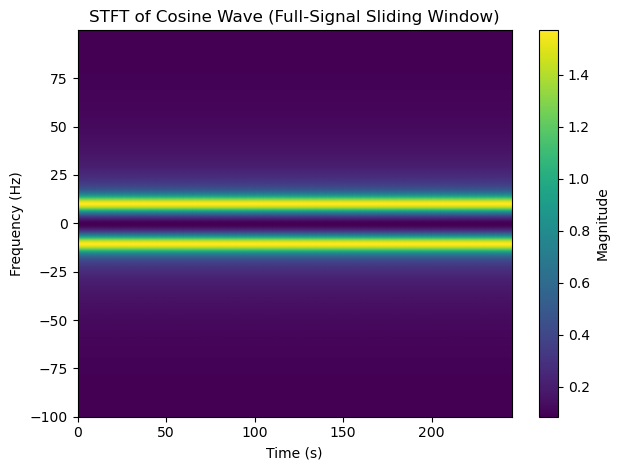

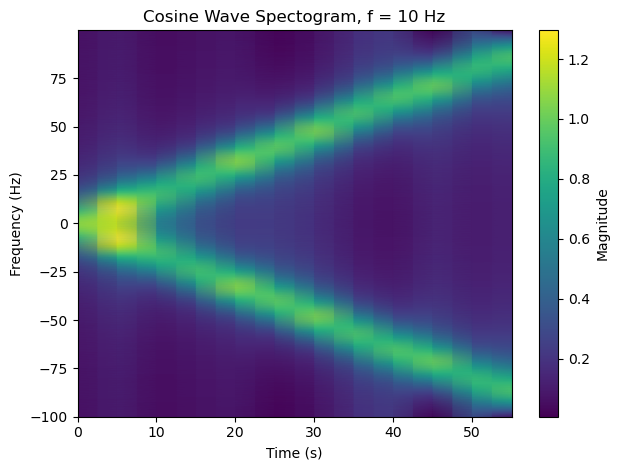

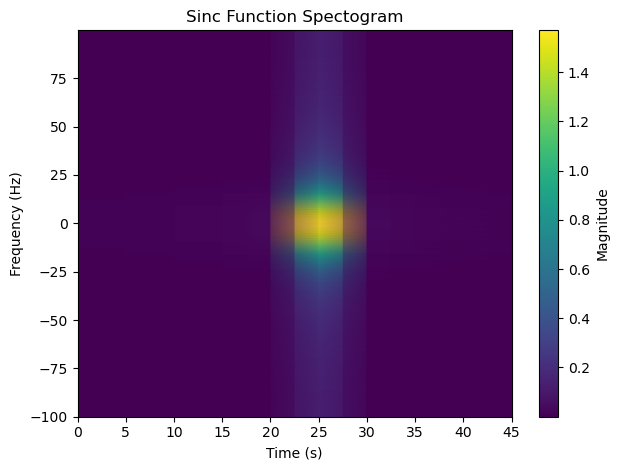

In [44]:
f0 = 10
sr = 200
duration = 5.0   # seconds
N = int(duration * sr)
n = np.arange(N)
t = n / sr
x1 = np.cos(2 * np.pi * f0 * t)
x2 = np.cos(2*np.pi*t**2*f0+200)
center_time = (t[-1] - t[0]) / 2
x3 = sinc(f0 * (t - center_time))
#x3 = sinc(t*f0)
window_length1 = 20
window_length2 = 80
window_length3 = 100 
a1 = 1 / window_length / 15
a2= 1/window_length*3/7
a3 = 1 / (window_length3*0.8)
X1 = my_stft3(x1, window_length1, a1)
plot_stft(X1, 'STFT of Cosine Wave (Full-Signal Sliding Window)', N, sr)
X2 = my_stft3(x2, window_length2, a2)
plot_stft(X2, 'Cosine Wave Spectogram, f = 10 Hz', N, sr)
X3 = my_stft3(x3, window_length3, a3)
plot_stft(X3, 'Sinc Function Spectogram', N, sr)